In [1]:
SEQ_LEN = 1
FUTURE_PERIOD_PREDICT = 1
EPOCH = 5
BATCH_SIZE = 64

import tensorflow as tf

import numpy as np
import pandas as pd
from sklearn import preprocessing
from collections import deque

from sklearn import model_selection

import random
from time import gmtime, strftime
from datetime import datetime
import itertools
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM,Activation, Dropout, BatchNormalization

import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_excel("[official] 특수일_00-18_dataset_v1_190310.xlsx", sheet_name = 'data', index_col = 0)
data.dropna(inplace = True)


In [2]:
data.columns.tolist()

['year',
 'month',
 'date',
 'hour',
 'day',
 'elec',
 'elec_dt',
 'temp_su',
 'temp_ic',
 'temp_sw',
 'temp_wj',
 'temp_dj',
 'temp_dg',
 'temp_gj',
 'temp_bs',
 'temp_tt',
 'sensoryt_su',
 'sensoryt_ic',
 'sensoryt_sw',
 'sensory_wj',
 'sensoryt_dj',
 'sensoryt_dg',
 'sensoryt_gj',
 'sensoryt_bs',
 'sensoryt_tt',
 'discomfort_su',
 'discomfort_ic',
 'discomfort_sw',
 'discomfort_wj',
 'discomfort_dj',
 'discomfort_dg',
 'discomfort_gj',
 'discomfort_bs',
 'discomfort_tt',
 'humid_su',
 'humid_ic',
 'humid_sw',
 'humid_wj',
 'humid_dj',
 'humid_dg',
 'humid_gj',
 'humid_bs',
 'humid_tt',
 'radiation_su',
 'radiation_ic',
 'radiation_sw',
 'radiation_wj',
 'radiation_dj',
 'radiation_dg',
 'radiation_gj',
 'radiation_bs',
 'radiation_tt',
 'sunshine_su',
 'sunshine_ic',
 'sunshine_sw',
 'sunshine_wj',
 'sunshine_dj',
 'sunshine_dg',
 'sunshine_gj',
 'sunshine_bs',
 'sunshine_tt',
 'cloud_su',
 'cloud_ic',
 'cloud_sw',
 'cloud_wj',
 'cloud_dj',
 'cloud_dg',
 'cloud_gj',
 'cloud_bs',
 'c

In [23]:
pm3 = data.copy()
pm3 = data.iloc[1:,:]
#pm3.columns[:5]

In [24]:
pm3.columns

Index(['year', 'month', 'date', 'hour', 'day', 'elec', 'elec_dt', 'temp_su',
       'temp_ic', 'temp_sw',
       ...
       'ss19', 'ss20', 'ss21', 'ss21_hol', 'ss22', 'ss22_a', 'ss_all', 'ss23',
       'ss24', 'ss25'],
      dtype='object', length=118)

In [25]:
pm3.head()

,year,month,date,hour,day,elec,elec_dt,temp_su,temp_ic,temp_sw,...,ss19,ss20,ss21,ss21_hol,ss22,ss22_a,ss_all,ss23,ss24,ss25
time,,,,,,,,,,,,,,,,,,,,,
1/02/2000 00:00,2000,1,2,0,7,22219,-1648.5,6.8,8,6.7,...,0,0,0,0,0,0,0,0,0,0
1/02/2000 01:00,2000,1,2,1,7,20900,-2967.3,6.4,7.8,6.6,...,0,0,0,0,0,0,0,0,0,0
1/02/2000 02:00,2000,1,2,2,7,19820,-4048.6,6,8,5.9,...,0,0,0,0,0,0,0,0,0,0
1/02/2000 03:00,2000,1,2,3,7,19303,-4564.7,6.2,7.9,5.8,...,0,0,0,0,0,0,0,0,0,0
1/02/2000 04:00,2000,1,2,4,7,19228,-4639.6,6,7.6,5.8,...,0,0,0,0,0,0,0,0,0,0


In [26]:

scaler = preprocessing.MinMaxScaler()

if 1:
    cols = ['ss_all','temp_tt','humid_tt','day', 'wind_tt','rainfall_tt','elec']
    pm3 = pm3[cols]
    pm3 = pd.get_dummies(pm3, columns = ['day'])
    pm3['elec'] = pm3['elec']/100000
    pm3['shift_1'] = pm3['elec'].shift(1)
    pm3['shift_7'] = pm3['elec'].shift(7)

    pm3['humid_tt'] = scaler.fit_transform(np.array(pm3['humid_tt']).reshape(-1,1))
    pm3['temp_tt'] = scaler.fit_transform(np.array(pm3['temp_tt']).reshape(-1,1))

    pm3['wind_tt'] = scaler.fit_transform(np.array(pm3['wind_tt']).reshape(-1,1))
    pm3['rainfall_tt'] = scaler.fit_transform(np.array(pm3['rainfall_tt']).reshape(-1,1))    

    re_cols = ['ss_all', 'temp_tt', 'humid_tt', 'wind_tt', 'rainfall_tt', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'shift_1', 'shift_7','elec' ]
    pm3 = pm3[re_cols]
    pm3.dropna(inplace = True)

print(len(pm3.columns))

/Users/yujinchung/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/yujinchung/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/yujinchung/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/yujinchung/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


15


In [38]:
# 어린이날 2017-5-5

if 0: 
    tr = pm3.loc[:'1/31/2017 {}'.format(t), :]
    val = pm3.loc['2/01/2017 {}'.format(t):'4/30/2017 {}'.format(t),:]
    te = pm3.loc['5/01/2017 {}'.format(t):'5/10/2017 {}'.format(t),:]

# 광복절 2017-8-15 
elif 0:
    tr = pm3.loc[:'5/31/2017 {}'.format(t), :]
    val = pm3.loc['6/01/2017 {}'.format(t):'8/10/2017 {}'.format(t),:]
    te = pm3.loc['8/11/2017 {}'.format(t):'8/20/2017 {}'.format(t),:]

# 성탄절 2017-12-25
elif 0:
    tr = pm3.loc[:'8/31/2017 {}'.format(t), :]
    val = pm3.loc['9/01/2017 {}'.format(t):'12/20/2017 {}'.format(t),:]
    te = pm3.loc['12/21/2017 {}'.format(t):'12/30/2017 {}'.format(t),:]
    
# 석탄일 2017-5-4
elif 0:
    tr = pm3.loc[:'1/31/2017 {}'.format(t), :]
    val = pm3.loc['2/01/2017 {}'.format(t):'4/28/2017 {}'.format(t),:]
    te = pm3.loc['4/29/2017 {}'.format(t):'5/08/2017 {}'.format(t),:]
elif 1:

    tr = pm3.loc[:'8/31/2017 00:00', :]
    val = pm3.loc['9/01/2017 01:00':'12/20/2017 00:00']
    te = pm3.loc['12/21/2017 01:00':'12/30/2017 00:00']
    
'''
======================
전체 시간 모형 
======================

'''    
# 전체 시간 모형 
# 성탄절 2017-12-25


'\n======================\n전체 시간 모형 \n======================\n\n'

In [40]:
print("TRAIN: {}\nTEST: {}\nVAL: {}".format(tr.shape, te.shape, val.shape))


TRAIN: (154818, 15)
TEST: (216, 15)
VAL: (2640, 15)


In [60]:
te.head()

,ss_all,temp_tt,humid_tt,wind_tt,rainfall_tt,day_1,day_2,day_3,day_4,day_5,day_6,day_7,shift_1,shift_7,elec
time,,,,,,,,,,,,,,,
12/21/2017 01:00,0,0.284872,0.980202,0.897347,0.0,0,0,0,1,0,0,0,0.68957,0.78706,0.66179
12/21/2017 02:00,0,0.273084,0.979102,0.898501,0.0,0,0,0,1,0,0,0,0.66179,0.76085,0.64714
12/21/2017 03:00,0,0.263261,0.980702,0.895040,0.0,0,0,0,1,0,0,0,0.64714,0.7391,0.6411
12/21/2017 04:00,0,0.255403,0.982202,0.901961,0.0,0,0,0,1,0,0,0,0.6411,0.71902,0.64607
12/21/2017 05:00,0,0.247544,0.982402,0.895040,0.0,0,0,0,1,0,0,0,0.64607,0.7138,0.66021


In [41]:
def _deque_df(df):
    

    sequential_data = []
    prev_points = deque(maxlen = SEQ_LEN)

    for i in df.values:
        prev_points.append([n for n in i[:-1]])
        if len(prev_points) == SEQ_LEN:
            sequential_data.append([np.array(prev_points), i[-1]])

    #random.shuffle(sequential_data)

    X = []
    y = []

    for seq, target in sequential_data:
        X.append(seq)
        y.append(target)

    return np.array(X), np.array(y)



train_X, train_y = _deque_df(tr)
validation_X, validation_y = _deque_df(val)
test_X, test_y = _deque_df(te)

In [44]:
print(train_X)
print(train_y)

[[['0' '0.4263261296660118' '0.9888011198880112' ... '1' '0.1944'
   '0.22219']]

 [['0' '0.43222003929273084' '0.9903009699030098' ... '1' '0.19557'
   '0.209']]

 [['0' '0.4381139489194499' '0.9877012298770124' ... '1' '0.19814'
   '0.1982']]

 ...

 [['0' '0.7053045186640471' '0.9748025197480252' ... '0' '0.62925'
   '0.68797']]

 [['0' '0.6954813359528487' '0.9763023697630238' ... '0' '0.60547'
   '0.68673']]

 [['0' '0.6856581532416502' '0.9790020997900211' ... '0' '0.59188'
   '0.67667']]]
[0.19557 0.19814 0.2087  ... 0.60547 0.59188 0.55488]


In [46]:

print(f"train X shape: {train_X.shape} train y shape: {train_y.shape}")
print(f"val X shape: {validation_X.shape} val y shape: {validation_y.shape}")
print(f"test X shape: {test_X.shape} test y shape: {test_y.shape}")





train X shape: (154818, 1, 14) train y shape: (154818,)
val X shape: (2640, 1, 14) val y shape: (2640,)
test X shape: (216, 1, 14) test y shape: (216,)


In [48]:
if 1: 
    train_X = train_X.reshape(154818,14)
    validation_X = validation_X.reshape(2640,14)
    test_X = test_X.reshape(216,14)
elif 0: # 요일더미 넣었을 때 
    train_X = train_X.reshape(6233,14)
    validation_X = validation_X.reshape(87,14)
    test_X = test_X.reshape(10,14)

In [49]:
model = Sequential()
model.add(Dense(14, activation='relu', input_dim=14))
model.add(Dense(16, activation='relu', input_dim=14))
#model.add(Dense(32, activation='relu', input_dim=16))
model.add(Dense(16, activation='relu', input_dim=32))
model.add(Dense(8, activation='relu', input_dim=16))
model.add(Dense(1, activation='relu'))
model.compile(optimizer='Adam',
              loss='mse',
              metrics=['accuracy'])

opt = tf.keras.optimizers.Adam(lr = 0.001, decay = 1e-6)

model.compile(loss = 'mse', optimizer = opt, metrics = ['accuracy'])

#start = datetime.now()
model.fit(train_X, train_y, batch_size = BATCH_SIZE,
                                        epochs = 5,
         validation_data = (validation_X, validation_y))

pred = model.predict(test_X)
pred = list(itertools.chain(*pred))




Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 154818 samples, validate on 2640 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
154818/154818 [==============================] - 5s 32us/sample - loss: 0.0031 - acc: 0.0000e+00 - val_loss: 4.6002e-04 - val_acc: 0.0000e+00
Epoch 2/5
154818/154818 [==============================] - 4s 29us/sample - loss: 3.2324e-04 - acc: 0.0000e+00 - val_loss: 4.0744e-04 - val_acc: 0.0000e+00
Epoch 3/5
154818/154818 [==============================] - 4s 29us/sample - loss: 3.1507e-04 - acc: 0.0000e+00 - val_loss: 3.9339e-04 - val_acc: 0.0000e+00
Epoch 4/5
154818/154818 [==============================] - 5s 29us/sample - loss: 3.0865e-04 - acc: 0.0000e+00 - val_loss: 4.3480e-04 - val_acc: 0.0000e+00
Epoch 5/5
154818/154818 [==============================] - 5s 33us/sample - loss: 3.0532e-04 - acc: 0.0000e+00 - val_loss: 3.8176e-04 - val_acc: 0.0000e+00


In [50]:
result = pd.DataFrame({'y_true':test_y,'y_pred':pred})

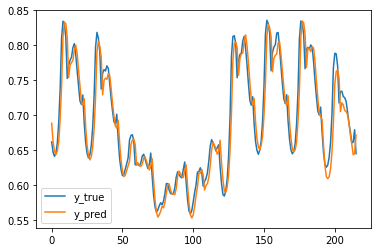

In [52]:
result.plot()

In [53]:
mape = np.mean(np.abs((test_y -pred) / test_y) * 100)
print(mape)

2.464378475136839


In [97]:
result

,y_true,y_pred
0,0.66179,0.688453
1,0.64714,0.661885
2,0.64110,0.648230
3,0.64607,0.643626
4,0.66021,0.648811
5,0.68990,0.662811
6,0.73701,0.694637
7,0.80999,0.742004
8,0.83450,0.812139
9,0.83095,0.833374


/Users/yujinchung/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/yujinchung/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


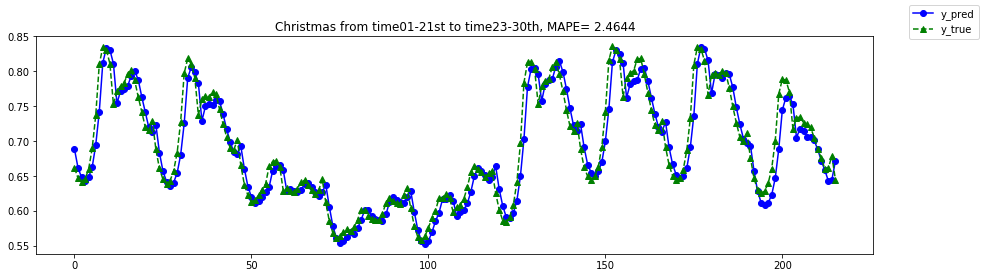

In [127]:
graph_result = result.copy()
graph_result.y_true = [float(i) for i in np.array(graph_result.y_true)]

fig = plt.figure(figsize = (15,4))
fig.show()
plt.title("Christmas from time01-21st to time23-30th, MAPE= {}".format(mape.round(4)))
ax=fig.add_subplot(111)
ax.plot(graph_result.index, graph_result.y_pred, c = 'b', marker = 'o')
ax.plot(graph_result.index, graph_result.y_true, c = 'g',ls = '--', marker = '^')
fig.legend()
#    plt.savefig('3rd_4SpecialDays_v1/Children {}.png'.format(T))
 #   result.to_csv("3rd_4SpecialDays_v1/Children {}.csv".format(T))

In [57]:
test_X.shape

(216, 14)

/Users/yujinchung/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/yujinchung/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


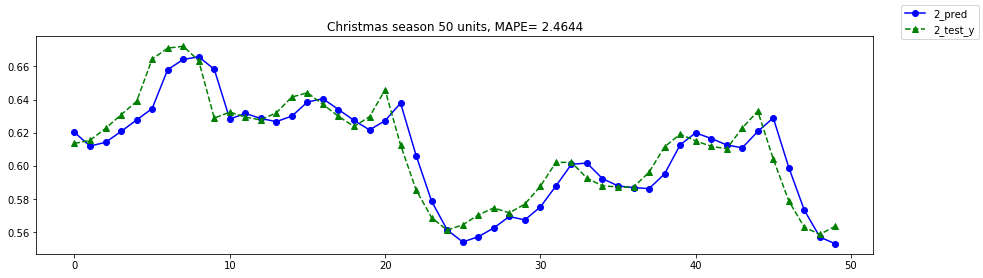

In [125]:
# 실험1, 테스트셋을 연속으로 놓지 않는다, 갑자기 끊어서 중간부터 보기
#pred2 = model.predict(test_X[100:])
#pred2 = list(itertools.chain(*pred))
if 1: 
    trial2_test_X = test_X[50:100]
    trial2_test_y = test_y[50:100]
    pred2 = model.predict(trial2_test_X)
    mape_trial2 = np.mean(np.abs((trial2_test_y-pred2)/trial2_test_y)*100)
    #print(mape_trial2)
    pred2 = list(itertools.chain(*pred2))
    trial2 = pd.DataFrame({'2_test_y':trail2_test_y, '2_pred': pred2})
    #print(trial2)
    graph_result = trial2.copy()
    #graph_result.2_test_y = [float(i) for i in np.array(graph_result.y_true)]

    fig = plt.figure(figsize = (15,4))
    fig.show()
    plt.title("Christmas season 50 units, MAPE= {}".format(mape.round(4)))
    ax=fig.add_subplot(111)
    ax.plot(graph_result.index, graph_result['2_pred'], c = 'b', marker = 'o')
    ax.plot(graph_result.index, graph_result['2_test_y'], c = 'g',ls = '--', marker = '^')
    fig.legend()
    
# 실험2, 테스트셋을 연속으로 두지 않고 일정 시간대만 뽑아본다
elif 0:
    T = 15
    pm4 = data.copy()
    pm4 = data[data.hour ==T]
    pm4.dropna(inplace = True)

# 실험3, 테스트셋 랜덤 샘플링 진행해서 확인 (전체 셋에서 랜덤시드 넣어 진행하고, 그 다음에 deque function) 
elif 0: 
    pass

/Users/yujinchung/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/yujinchung/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


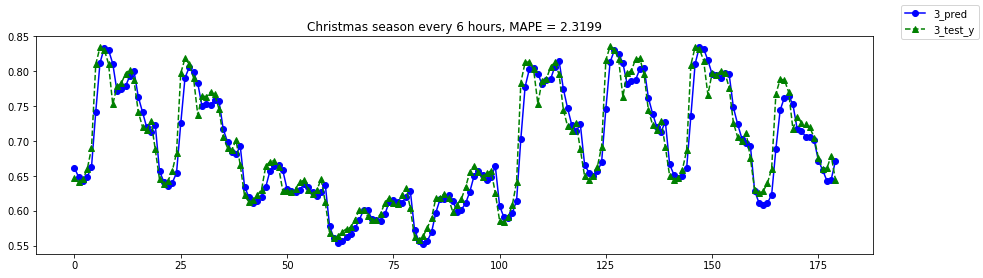

In [126]:
if 0: 
    trial2_test_X = test_X[50:100]
    trial2_test_y = test_y[50:100]
    pred2 = model.predict(trial2_test_X)
    mape_trial2 = np.mean(np.abs((trial2_test_y-pred2)/trial2_test_y)*100)
    print(mape_trial2)
    pred2 = list(itertools.chain(*pred2))
    trial2 = pd.DataFrame({'2_test_y':trail2_test_y, '2_pred': pred2})
    print(trial2)
    graph_result = trial2.copy()
    #graph_result.2_test_y = [float(i) for i in np.array(graph_result.y_true)]

    fig = plt.figure(figsize = (15,4))
    fig.show()
    plt.title("Christmas season 50 units, MAPE= {}".format(mape_trial2.round(4)))
    ax=fig.add_subplot(111)
    ax.plot(graph_result.index, graph_result['2_pred'], c = 'b', marker = 'o')
    ax.plot(graph_result.index, graph_result['2_test_y'], c = 'g',ls = '--', marker = '^')
    fig.legend()
    
# 실험2, 테스트셋을 연속으로 두지 않고 일정 시간대만 뽑아본다
# 실험2' 

def _sample(array, step):
    # df.iloc[::10]
    return [v for i,v in enumerate(array) if i%step]


if 1:
    trial3_test_X = np.asarray(_sample(test_X, 6))
    trial3_test_y = np.asarray(_sample(test_y, 6))
    pred3 = model.predict(trial3_test_X)
    pred3 = list(itertools.chain(*pred3))
    trial3 = pd.DataFrame({"3_test_y":trial3_test_y, "3_pred": pred3})
    mape_trial3 = np.mean(np.abs((trial3_test_y-pred3)/trial3_test_y)*100)
    #print(mape_trial3)  
    #print(trial3)
    graph_result = trial3.copy()
    
    fig = plt.figure(figsize= (15,4))
    fig.show()
    plt.title('Christmas season every 6 hours, MAPE = {}'.format(mape_trial3.round(4)))
    ax = fig.add_subplot(111)
    ax.plot(graph_result.index, graph_result['3_pred'], c = 'b', marker = 'o')
    ax.plot(graph_result.index, graph_result['3_test_y'], c = 'g', ls = '--', marker = '^')
    fig.legend()

In [128]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 14)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                240       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 867
Trainable params: 867
Non-trainable params: 0
_________________________________________________________________
